In [1]:
! pip install opencv-python

In [2]:
import os
import sys
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
training_data = []
def create_training_data():
    
    DATADIR_night = r'C:\Users\Admin\Documents\DayNight_Classifier\NightPhotos'
    DATADIR_day = r'C:\Users\Admin\Documents\DayNight_Classifier\DayPhotos'
    class_name_night = 1
    class_name_day = 0
    
    for img in os.listdir(DATADIR_night):
        try:
            img_array = cv2.imread(os.path.join(DATADIR_night, img))
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            training_data.append([img_array, class_name_night])
             
        except Exception as e:
            pass
        
    for img in os.listdir(DATADIR_day):
        try:
            img_array = cv2.imread(os.path.join(DATADIR_day, img))
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            training_data.append([img_array, class_name_day])
             
        except Exception as e:
            pass
        
create_training_data()

In [4]:
print(len(training_data))

1000


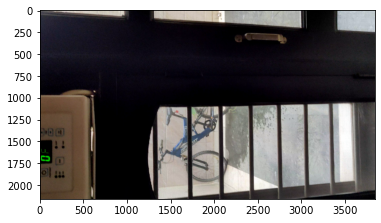

In [5]:
plt.imshow(training_data[501][0])
plt.show()

In [6]:
import random
random.shuffle(training_data)

for sample in training_data[:10]:
    print(sample[1])

0
0
0
1
0
0
1
0
0
1


In [7]:
X = []
y = []

In [8]:
IMG_SIZE = 64
for features, label in training_data:
    img_array = cv2.resize(features, (IMG_SIZE, IMG_SIZE))
    X.append(img_array)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [9]:
X.shape

(1000, 64, 64, 3)

In [10]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [11]:
pickle_in = open("X.pickle", "rb")
X1 = pickle.load(pickle_in)
X1 = np.array(X1)

In [12]:
pickle_in = open("y.pickle", "rb")
y1 = pickle.load(pickle_in)
y1 = np.array(y1)

In [13]:
Xf = []
for i in range(len(X)):
    Xf.append(X[i].flatten())
Xf = np.array(Xf)
Xf.shape

(1000, 12288)

In [14]:
X_train = Xf[:800]
X_test = Xf[800:]
y_train = y1[:800]
y_test = y1[800:]

In [15]:
X_train = X_train/255.
X_test = X_test/255.
y_train = y_train.reshape(1,800)
y_test = y_test.reshape(1,200)

In [16]:
X_train.shape

(800, 12288)

In [17]:
import numpy as np

W1 = None
b1 = None
W2 = None
b2 = None

#I = input_size
#H = hidden_size
#O = output_size

In [18]:
def Initialization(I, H, O):
    global W1, b1, W2, b2
    std = 1e-4
    W1 = np.random.rand(H, I)*0.01
    b1 = np.zeros((H,1))
    W2 = np.random.rand(O, H)*0.01
    b2 = np.zeros((O,1))

In [19]:
def feed_forward(X1):
    global W1, b1, W2, b2
    z1 = np.add(np.dot(W1, X1), b1)
    a1 = np.maximum(z1, 0) #relu
    z2 = np.add(np.dot(W2, a1), b2)
    a2 = 1/(1 + np.exp(-z2)) #sigmoid
    return a2

In [20]:
def loss_compute(y, yd, X1):
    #cross entropy loss
    #print(yd.shape)
    loss = (-1/yd.shape[1])*(np.sum(np.multiply(np.log(y), yd)) + np.sum(np.multiply(np.log(1 - y), 1 - yd)))
    loss = np.squeeze(loss)
    
    grads = Backpropagation(X1, yd)
    return loss, grads

In [21]:
def dSigmoid(x):
    s = 1/(1+np.exp(-x))
    dz = s * (1-s)
    return dz

drelu = np.vectorize(lambda x: 1 if x>=0 else 0)

In [22]:
def Backpropagation(X1, yd):
    global W1, b1, W2, b2
    
    grads = {}
    m = X1.shape[1]
    z1 = np.add(np.dot(W1, X1), b1)
    a1 = np.maximum(z1, 0) #relu
    z2 = np.add(np.dot(W2, a1), b2)
    a2 = 1/(1 + np.exp(-z2)) #sigmoid
    y = a2
    
    da2 = -(np.divide(yd, y) - np.divide(1 - yd, 1 - y))
    
    dz2 = np.multiply(da2, dSigmoid(z2))
    
    da1 = (1/m)*np.dot(W2.T, dz2)

    dW2 = (1/m)*np.dot(dz2, a1.T)
 
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)

    dz1 = np.multiply(da1, drelu(z1))

    dW1 = (1/m)*np.dot(dz1, X1.T)

    db1 = (1/m)*np.sum(dz1, axis=1, keepdims = True)
    
    da0 = (1/m)*np.dot(W1.T, dz1)

    
    grads['W1'] = dW1
    grads['b1'] = db1
    grads['W2'] = dW2
    grads['b2'] = db2
    

    return grads

In [29]:
def training(X, yd, eta = 1e-3, num_iters=12000, batch_size = 150, verbose = False):
    
            loss_history = []
            num_train = X.shape[1]
            np.random.seed(1)
            global W1, b1, W2, b2
            Initialization(12288, 25, 1)
    
            for it in range(num_iters+1):
    
                dataset_size = X.shape[1]
                iterations_per_epoch = max(num_train / batch_size, 1)
                start = (num_iters * batch_size)%dataset_size

                X_batch = X.T[start: start + batch_size]
                yd_batch = yd[:,0:batch_size]
                y = feed_forward(X_batch.T)
                loss, grads = loss_compute(y, yd_batch, X_batch.T)
                loss_history.append(loss)
    
        
                if(it%1000 == 0):
                    print('iteration + loss')
                    print(it, loss)
            
        
                W1 -= eta * grads['W1']
                W2 -= eta * grads['W2']
                b1 -= eta * grads['b1']
                b2 -= eta * grads['b2']
        
            return {
                'loss history' : loss_history
            }

In [30]:
f = training(X_train.T, y_train)

iteration + loss
0 1.852770370295707
iteration + loss
1000 0.5990749521898935
iteration + loss
2000 0.5828803436593843
iteration + loss
3000 0.5672514524617871
iteration + loss
4000 0.5516315642927473
iteration + loss
5000 0.5353641744945924
iteration + loss
6000 0.5177101566724046
iteration + loss
7000 0.4979603320647473
iteration + loss
8000 0.4756880400418944
iteration + loss
9000 0.45109925434987636
iteration + loss
10000 0.42524658172998675
iteration + loss
11000 0.399781221056495
iteration + loss
12000 0.37625575907081255


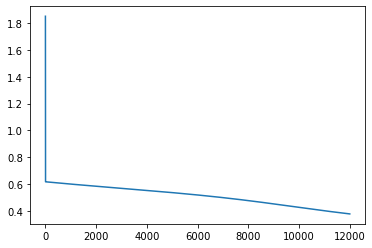

In [31]:
plt.plot(f['loss history'])

In [32]:
def predict(X, yd):
    m = X.shape[1] 
    y = feed_forward(X)
    f = np.zeros((1,m))
    
    for i in range(0, y.shape[1]):
        if(y[0][i] > 0.5):
            f[0][i] = 1
        else:
            f[0][i] = 0
    
    acc = np.sum((f == yd)/m)
    
    print("Accuracy:- ", acc)
    
predict(X_train.T, y_train) 
predict(X_test.T, y_test)
    

Accuracy:-  0.91375
Accuracy:-  0.9699999999999999


In [33]:
def predict_test(X, yd):
    m = X.shape[1] 
    y = feed_forward(X)
    f = np.zeros((1,m))
    
    for i in range(0, y.shape[1]):
        if(y[0][i] > 0.5):
            f[0][i] = 1
        else:
            f[0][i] = 0
    return f

Your model returned '0' which implies 'Day'


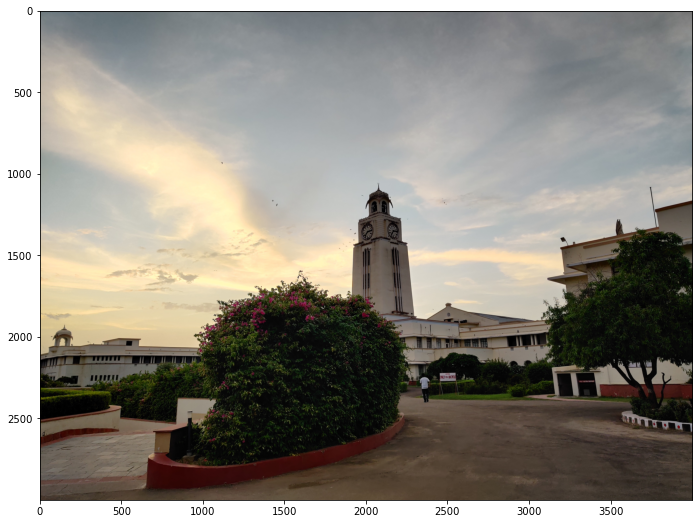

In [34]:
DATADIR = r'C:\Users\Admin\Documents\DayNight_Classifier\test_sample'
IMG_SIZE = 64
img = "IMG_20190822_190125.jpg"
class_name = 0 # Night
classes = ['Day', 'Night']
img_array = cv2.imread(os.path.join(DATADIR, img))
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
img_array_test = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img_array_test_flatten = img_array_test.reshape(1,-1).T
img_array_test = img_array_test_flatten/255.
pred_test = predict_test(img_array_test, 1)
print("Your model returned '{}' which implies '{}'".format(str(int(np.squeeze(pred_test))), classes[int(np.squeeze(pred_test))]))
plt.figure(figsize = (50,9))
plt.imshow(img_array)
plt.show()

Your model returned '0' which implies 'Day'


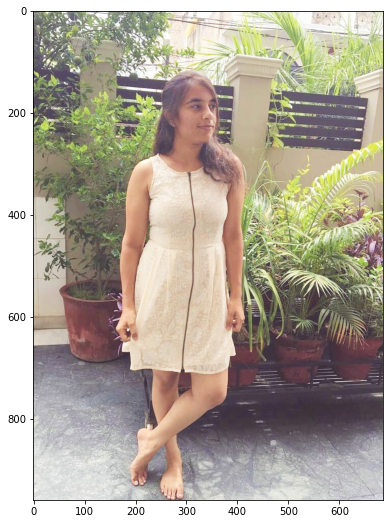

In [35]:
DATADIR = r'C:\Users\Admin\Documents\DayNight_Classifier\test_sample'
IMG_SIZE = 64
img = "40638536_2182409722043731_2862904102910689280_n.jpg"
class_name = 0 # Day
classes = ['Day', 'Night']
img_array = cv2.imread(os.path.join(DATADIR, img))
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
img_array_test = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img_array_test_flatten = img_array_test.reshape(1,-1).T
img_array_test = img_array_test_flatten/255.
pred_test = predict_test(img_array_test, 1)
print("Your model returned '{}' which implies '{}'".format(str(int(np.squeeze(pred_test))), classes[int(np.squeeze(pred_test))]))
plt.figure(figsize = (50,9))
plt.imshow(img_array)
plt.show()

Your model returned '1' which implies 'Night'


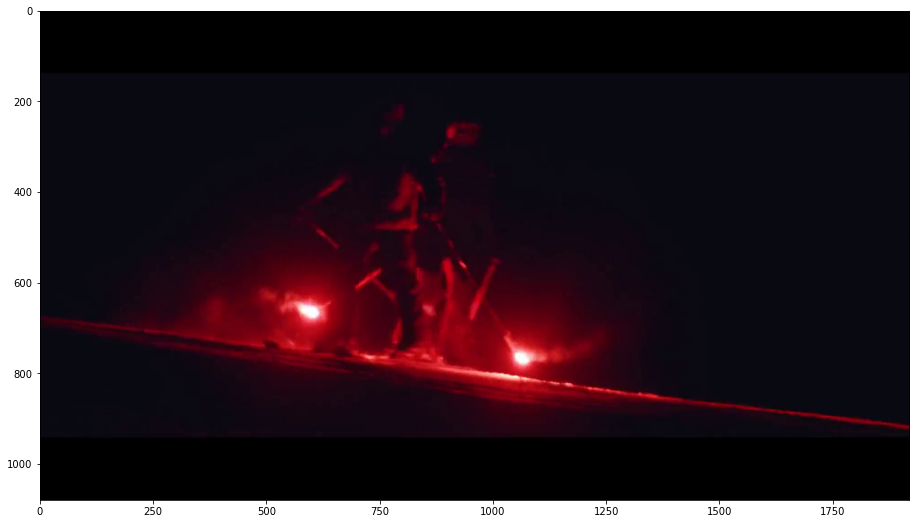

In [39]:
DATADIR = r'C:\Users\Admin\Documents\DayNight_Classifier\test_sample'
IMG_SIZE = 64
img = "vlcsnap-2020-06-20-16h49m30s542.png"
class_name = 1 # Night
classes = ['Day', 'Night']
img_array = cv2.imread(os.path.join(DATADIR, img))
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
img_array_test = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img_array_test_flatten = img_array_test.reshape(1,-1).T
img_array_test = img_array_test_flatten/255.
pred_test = predict_test(img_array_test, 1)
print("Your model returned '{}' which implies '{}'".format(str(int(np.squeeze(pred_test))), classes[int(np.squeeze(pred_test))]))
plt.figure(figsize = (50,9))
plt.imshow(img_array)
plt.show()

Your model returned '1' which implies 'Night'


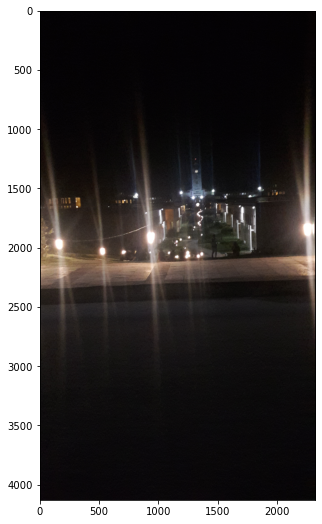

In [43]:
DATADIR = r'C:\Users\Admin\Documents\DayNight_Classifier\test_sample'
IMG_SIZE = 64
img = "20180731_215450.jpg"
class_name = 1 # Night
classes = ['Day', 'Night']
img_array = cv2.imread(os.path.join(DATADIR, img))
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
img_array_test = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img_array_test_flatten = img_array_test.reshape(1,-1).T
img_array_test = img_array_test_flatten/255.
pred_test = predict_test(img_array_test, 1)
print("Your model returned '{}' which implies '{}'".format(str(int(np.squeeze(pred_test))), classes[int(np.squeeze(pred_test))]))
plt.figure(figsize = (50,9))
plt.imshow(img_array)
plt.show()